# IT3105 - JAX Project - Elias Lerheim Birkeland


In [1]:
import sys
sys.path.append("../src/")

from classic_pid_controller import ClassicPidController
from neural_pid_controller import NeuralPidController
from bathtub import Bathtub
from cournot import CournotCompetition
from rabbits import Rabbits
from consys import ConSys
from plot_utils import plot_classic_pid, plot_nn_pid

## Classic PID controller

### Bathtub

Summary: There is not much to say about this run. The pid parameters are initialized to the same values as the graph in the 'jax-controller.pdf' file. The system is simple, and it seems that we get a smoothly decreasing MSE with pretty much any reasonable consys and controller parameters.

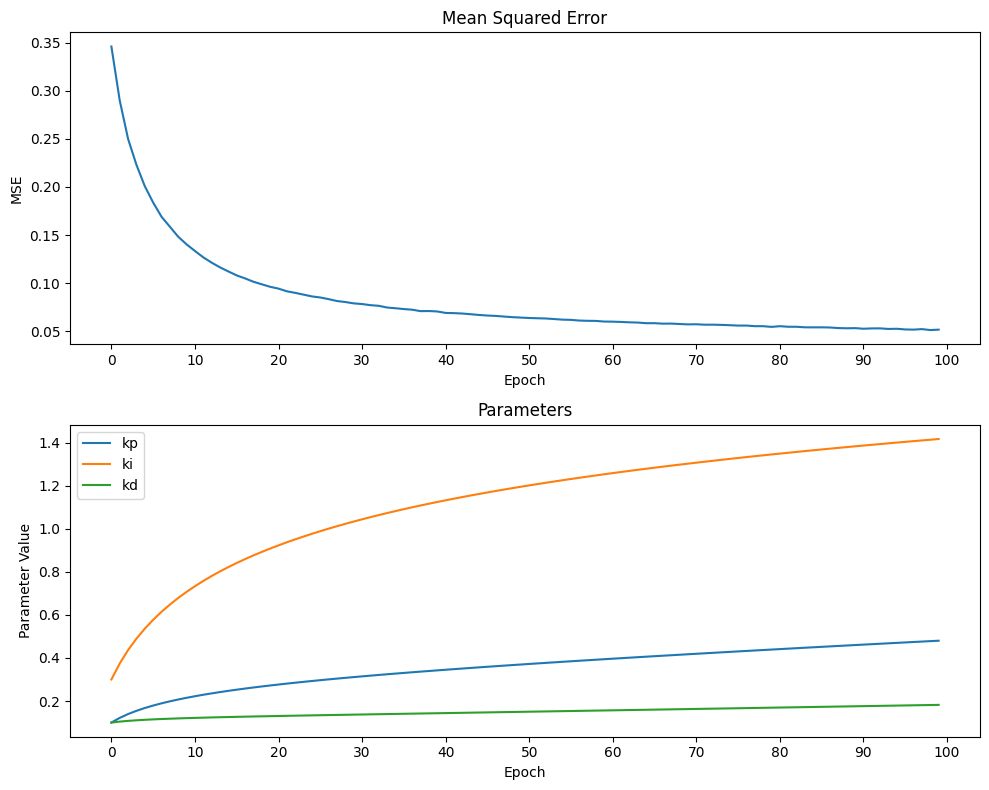

In [2]:
### Bathtub params:
A = 10.0      # cross-sectional area
C = A/100   # cross-sectional-drain area
H = 10.0      # initial height
g = 9.8     # gravitational constant

### ConSys params:
no_epochs = 100
timesteps_per_epoch = 10
learning_rate = 0.1
min_noise_value = -0.01
max_noise_value = 0.01

### Controller params:
controller_params = [0.1, 0.3, 0.1]     # kp, ki, kd

controller = ClassicPidController()
plant = Bathtub(A, C, H, g)
consys = ConSys(controller, plant, no_epochs, timesteps_per_epoch, learning_rate, min_noise_value, max_noise_value)
mse_list, params_matrix = consys.simulate(controller_params, verbose=False)

plot_classic_pid(mse_list, params_matrix)


### Cournot

Summary: I struggled with getting nice results from the Cournot plant, but by setting the Cournot plant parameters to something I knew would reach an equilibrium I got it working. In this system, the competitor (plant 2) will produce 0.3 +- noise every timestep. Producer 1 starts by producing nothing and their optimal quantity will be either 0.6 or 1, which gives them the target profit of 0.6.

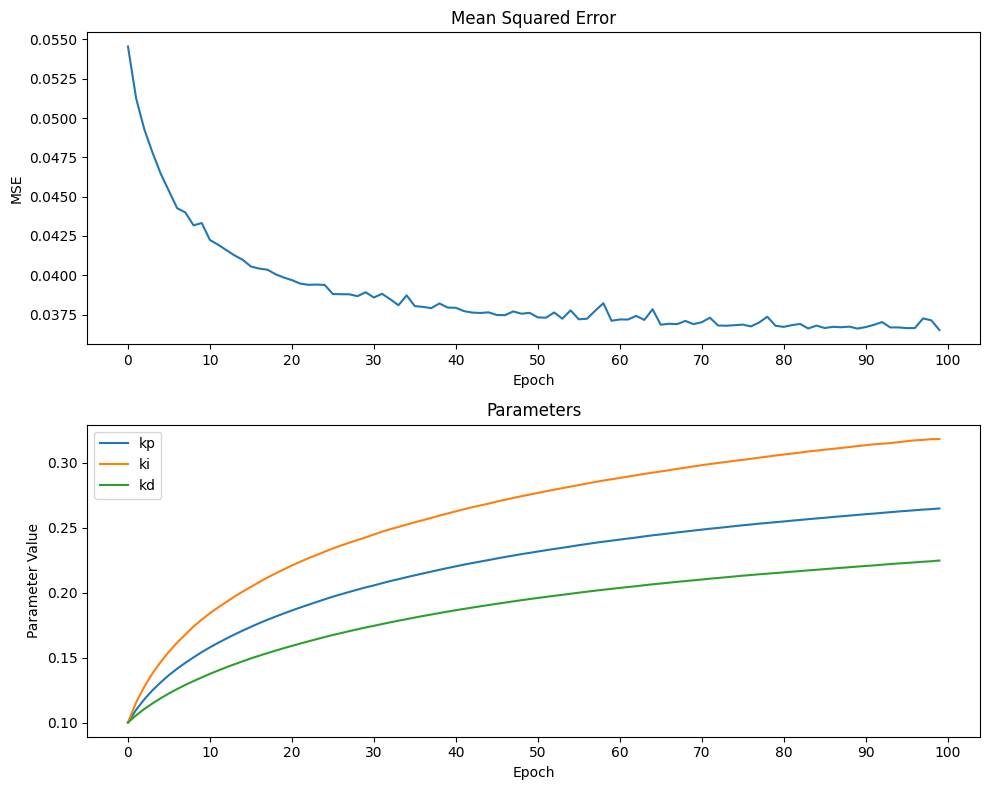

In [3]:
### CournoutCompetition params:
T = 0.6   # Target profit per timestep
c_m = 0.1  # Marginal cost
q1 = 0.0   # initial quantity produced by 1
q2 = 0.3   # initial quantity produced by 2
p_max = 2.0 # maximum market price

### ConSys params:
no_epochs = 100
timesteps_per_epoch = 10
learning_rate = 0.1
min_noise_value = -0.01
max_noise_value = 0.01

### Controller params:
controller_params = [0.1, 0.1, 0.1]     # kp, ki, kd

controller = ClassicPidController()
plant = CournotCompetition(target_profit=T, marginal_unit_cost=c_m, own_quantity=q1, competitor_quantity=q2, maximum_price=p_max)
consys = ConSys(controller, plant, no_epochs, timesteps_per_epoch, learning_rate, min_noise_value, max_noise_value)
mse_list, params_matrix = consys.simulate(controller_params, verbose=False)

plot_classic_pid(mse_list, params_matrix)

### Rabbits

Rabbits and foxes:
We will model a population of rabbits (z1) and foxes (z2), where the foxes prey
on the rabbits. Rabbits are born at rate a1 and die naturally at rate a2, and die due to interaction
with foxes at rate a3. In addition, due to external effects on the rabbits' birth rate, there is a time
varying, additive component + a4 sin(a5 · t). Rabbits killed by wildlife population control is 
represented by U (the control signal).

Foxes die naturally at rate b1 and are born from interaction with rabbits at rate b2. 
There is also some noise in the birthrate of foxes, represented by the term D (disturbance).
The change in rabbit and fox population per timestep is described by the following equations:

![This is an image](../img/rabbit_formula.png "Title of the image")


Task: keep rabbit population stable at initial population.
We assume that wildlife population management always make sure that neither the rabbit population nor the fox population
ever gets lower than 1 individual.

Summary: The plant parameters (aswell as the plant itself) I obtained from an exercise in a cybernetics course here at NTNU. The problem was not originally a controller-plant problem so the parameters might not be optimal for this task. I found that the rabbit population tended to explode if I used too many timesteps. The gradients also become very large compared to the PID parameters, which is why I use a very low learning rate.

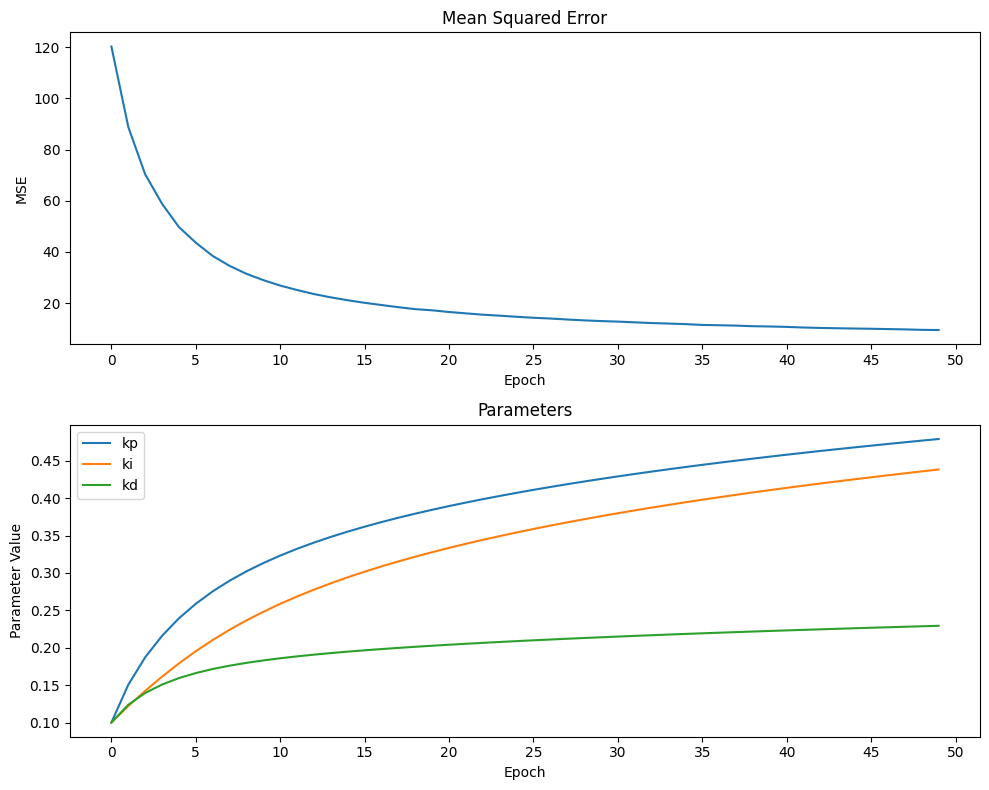

In [4]:
### Rabbit population params:
a1 = 0.35     # rabbit birth rate
a2 = 0.01     # rabbit natural death rate
a3 = 0.05     # rabbit killed by fox rate
a4 = 0.3      # rabbit external birthrate factors param 1
a5 = 0.4      # rabbit external birthrate factors param 2
b1 = 0.3      # fox natural death rate
b2 = 0.015    # fox birthrate
rabbit_start_population = 26
fox_start_population = 3

### ConSys params:
no_epochs = 50
timesteps_per_epoch = 10
learning_rate = 0.0001
min_noise_value = -0.01
max_noise_value = 0.01

### Controller params:
controller_params = [0.1, 0.1, 0.1]     # kp, ki, kd

controller = ClassicPidController()
plant = Rabbits(a1, a2, a3, a4, a5, b1, b2, rabbit_start_population, fox_start_population)
consys = ConSys(controller, plant, no_epochs, timesteps_per_epoch, learning_rate, min_noise_value, max_noise_value)
mse_list, params_matrix = consys.simulate(controller_params, verbose=False)

plot_classic_pid(mse_list, params_matrix)


## Neural PID Controller

### Bathtub

Summary: I used fewer epochs with more timesteps than the corresponding classic pid controller. It works with all the mandatory activation functions but I found that sigmoid in every layer gave a smooth plot :-)

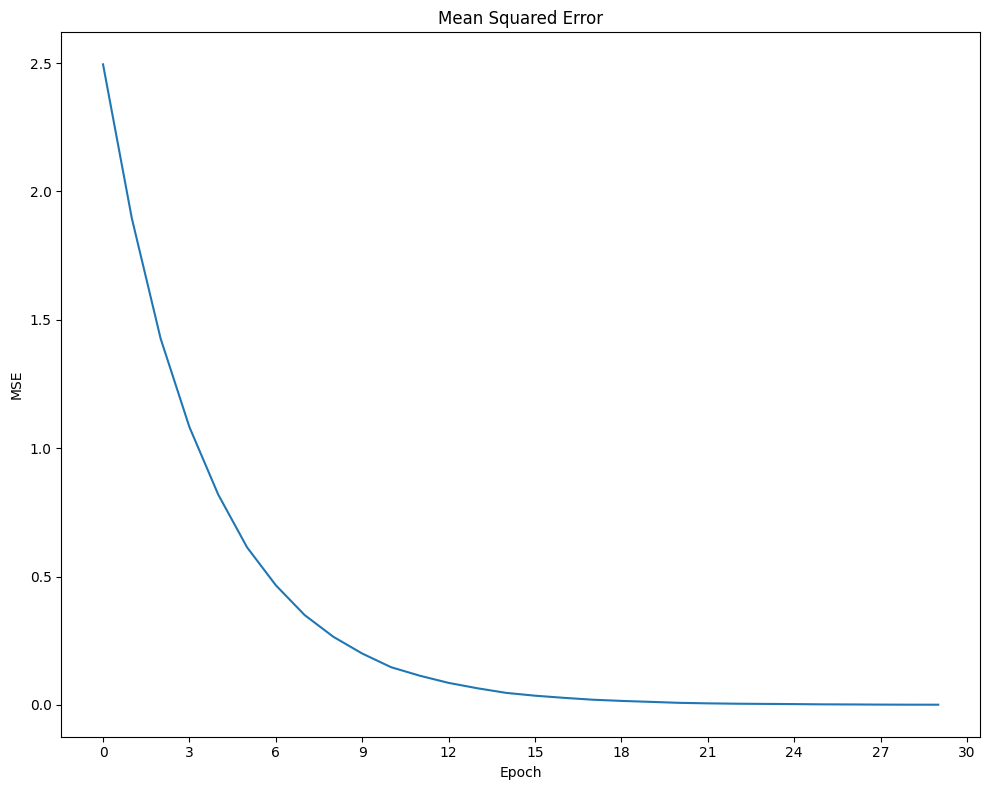

In [5]:
### Bathtub params:
A = 10.0      # cross-sectional area
C = A/100   # cross-sectional-drain area
H = 10.0      # initial height
g = 9.8     # gravitational constant

### ConSys params:
no_epochs = 30
timesteps_per_epoch = 20
learning_rate = 0.01
min_noise_value = -0.01
max_noise_value = 0.01

### Controller params:
hidden_layers = [16, 16, 16]
activation_funcs = ["sigmoid", "sigmoid", "sigmoid", "linear"]
min_weight_value = -0.1
max_weight_value = 0.1

controller = NeuralPidController(hidden_layers, activation_funcs, min_weight_value, max_weight_value)
plant = Bathtub(A, C, H, g)
consys = ConSys(controller, plant, no_epochs, timesteps_per_epoch, learning_rate, min_noise_value, max_noise_value)
mse_list = consys.simulate(verbose=False)

plot_nn_pid(mse_list)


### Cournot

Summary: Here I used all the possible activation functions and included an extra hidden layer compared to the bathtub.

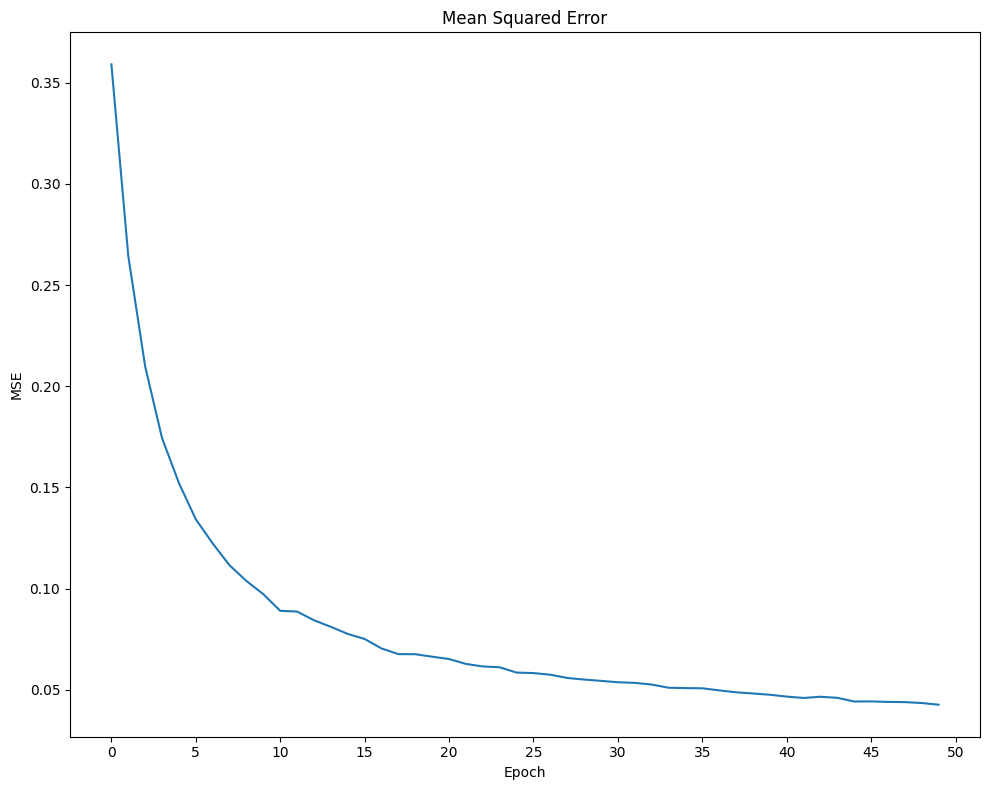

In [8]:
### CournoutCompetition params:
T = 0.6   # Target profit per timestep
c_m = 0.1   # Marginal cost
q1 = 0.0   # initial quantity produced by 1
q2 = 0.3   # initial quantity produced by 2
p_max = 2.0 # maximum market price

### ConSys params:
no_epochs = 50
timesteps_per_epoch = 10
learning_rate = 0.001
min_noise_value = -0.01
max_noise_value = 0.01

### Controller params:
hidden_layers = [16, 16, 16, 8]
activation_funcs = ["sigmoid", "tanh", "sigmoid", "relu", "linear"]
min_weight_value = - 0.01
max_weight_value = 0.01

controller = NeuralPidController(hidden_layers, activation_funcs, min_weight_value, max_weight_value)
plant = CournotCompetition(target_profit=T, marginal_unit_cost=c_m, own_quantity=q1, competitor_quantity=q2, maximum_price=p_max)
consys = ConSys(controller, plant, no_epochs, timesteps_per_epoch, learning_rate, min_noise_value, max_noise_value)
mse_list = consys.simulate(verbose=False)

plot_nn_pid(mse_list)


### Rabbits

Summary: For the mathematical model description, please refer to the "Rabbits" part in the "Classic PID Controller" section of this report. Interestingly, the classic PID controller seemed to work better, converging to a lower MSE (around 20 compared to 25). I did not have time to tune this system very much but in initial testing it seemed to converge to around 25 with various consys parameters and various number of hidden layers with different activations.

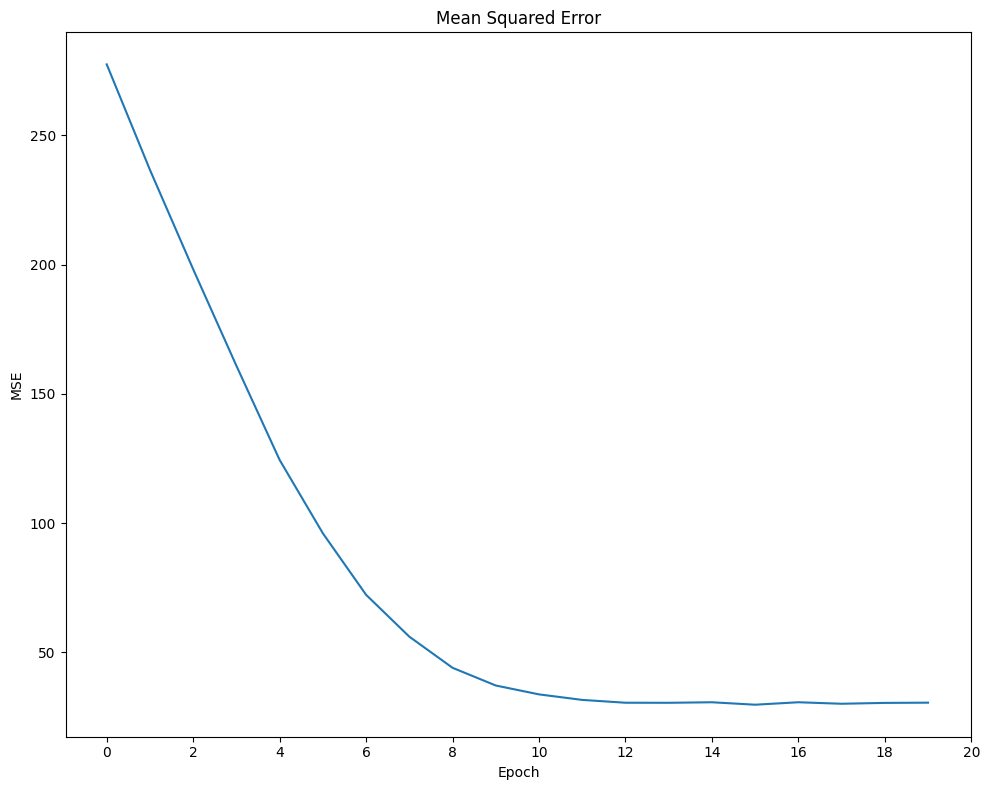

In [9]:
### Rabbit population params:
a1 = 0.35     # rabbit birth rate (originally 0.35)
a2 = 0.01     # rabbit natural death rate
a3 = 0.05     # rabbit killed by fox rate
a4 = 0.3      # rabbit external birthrate factors param 1
a5 = 0.4      # rabbit external birthrate factors param 2
b1 = 0.3      # fox natural death rate
b2 = 0.015    # fox birthrate
rabbit_start_population = 26
fox_start_population = 3

### ConSys params:
no_epochs = 20
timesteps_per_epoch = 10
learning_rate = 0.001
min_noise_value = -0.01
max_noise_value = 0.01

### Controller params:
hidden_layers = [16, 16, 16, 16, 16]
activation_funcs = ["sigmoid", "tanh", "relu", "sigmoid", "sigmoid", "linear"]
min_weight_value = - 0.1
max_weight_value = 0.1

controller = NeuralPidController(hidden_layers, activation_funcs, min_weight_value, max_weight_value, seed=42)
plant = Rabbits(a1, a2, a3, a4, a5, b1, b2, rabbit_start_population, fox_start_population)
consys = ConSys(controller, plant, no_epochs, timesteps_per_epoch, learning_rate, min_noise_value, max_noise_value)
mse_list = consys.simulate(verbose=False)

plot_nn_pid(mse_list)
